#### GOAL: 
Create a model which predicts a Role given a Job Description
    
##### Input Example: 
'Randstad Technical di Vimercate seleziona un manutentore per inserimento in somministrazione presso azienda del settore gomma plastica. La risorsa si occuperà della manutenzione ordinaria e straordinaria di presse a iniezione idrauliche  ed elettriche, di attrezzature elettromeccaniche e degli impianti del plant produttivo. Requisiti: diploma o qualifica in ambito meccanico o elettromeccanico; esperienza nella mansione di almeno 3 anni; disponibilità al lavoro sia a giornata che su tre turni; flessibilità, precisione, capacità organizzative, proattività'

##### Model outputs:
'Elettromeccanici'

### Import dependencies

In [475]:
# !pip install -r requirements.txt
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib
import re
import nltk
import numpy as np
from IPython.display import Image
import pickle
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')

### Load the data

In [422]:
professioni = pd.read_csv('data/professioni.csv')
dati_aprile = pd.read_csv('Job_vacancies_aprile_completo.csv', skiprows=1, usecols = [1,2,3],\
                          names = ['Target','Sub_Role','Job_Description'])
dati_aprile = dati_aprile.reindex(np.random.permutation(dati_aprile.index))
print('dati_aprile shape {}'.format(dati_aprile.shape))
dati_aprile[['Target','Job_Description']].head() # per facilitare la comprensione dei dati di testo da parte del modello

dati_aprile shape (650, 3)


,Target,Job_Description
576,Commessi delle vendite al minuto,ricerca ADDETTI ALLE VENDITE DI AUTO con esper...
126,Cuochi in alberghi e ristoranti,Per la sala di una prestigiosissima Azienda Fa...
326,Tecnici web,FULL STACK DEVELOPER - PROGRAMMAZIONE WEB ORIE...
331,Tecnici web,"Web Copywriter Gigasweb - Roma, Lazio Il candi..."
204,Statistici,Stiamo cercando un Business Intelligence Consu...


In [423]:
dati_aprile.Target.value_counts()

Commessi delle vendite al minuto    149
Statistici                          104
Camerieri di ristorante             100
Cuochi in alberghi e ristoranti     100
Elettromeccanici                     99
Tecnici web                          98
Name: Target, dtype: int64

### Text Preprocessing on Professioni csv

In [424]:
# professioni.Subgroup = professioni.Subgroup.apply(lambda x: x.lower().split('\n'))
# professioni.subgroup1 = professioni.subgroup1.apply(lambda x: x.lower().split('\n'))
# professioni.subgroup2 = professioni.subgroup2.apply(lambda x: x.lower().split('\n'))
# professioni.Subgroup = professioni.Subgroup + professioni.subgroup1 + professioni.subgroup2
# professioni.Subgroup = professioni.Subgroup.apply(lambda x: list(set(x)))

In [425]:
# professioni.head()

### Create a dictionary for professioni. e.g. 
{Statistici : ['attuario', 'data scientist', 'esperto in ricerca operativa',..... ]}

In [426]:
# professioni_dictionary = pd.Series(professioni.Subgroup.values,index=professioni.Group).to_dict()
# # to remove empty space from the subgroup list of values
# for i in range(0,professioni.Subgroup.shape[0]):
#     while("" in professioni.Subgroup.iloc[i]) : 
#         professioni.Subgroup.iloc[i].remove("") 

In [427]:
# professioni_dictionary

In [428]:
# # I need this step to convert back
# subgroup_dict = {}
# for group, subgroups in professioni_dictionary.items():
#     for subgroup in subgroups:
#         subgroup_dict[subgroup] = group
# subgroup_dict

### Text Preprocessing on Job Descripion column

#### Tokenization
split the text into words

In [429]:
# remove punctuation
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: re.sub('[^a-zA-Z]',' ',x))
dati_aprile.Target = dati_aprile.Target.apply(lambda x: x.lower()) #tutte le parole in minuscolo 
dati_aprile.Job_Description = dati_aprile['Job_Description'].apply(lambda x: word_tokenize(x.lower())) # lowercase each word
dati_aprile[['Target','Job_Description']].head()

,Target,Job_Description
576,commessi delle vendite al minuto,"[ricerca, addetti, alle, vendite, di, auto, co..."
126,cuochi in alberghi e ristoranti,"[per, la, sala, di, una, prestigiosissima, azi..."
326,tecnici web,"[full, stack, developer, programmazione, web, ..."
331,tecnici web,"[web, copywriter, gigasweb, roma, lazio, il, c..."
204,statistici,"[stiamo, cercando, un, business, intelligence,..."


remove words with lenght < 3 (e.g. numbers and not meaningful words)

In [430]:
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: [i for i in x if len(i) >= 3])
dati_aprile.Job_Description.head() # note the word 'vimercate' in row = 0

576    [ricerca, addetti, alle, vendite, auto, con, e...
126    [per, sala, una, prestigiosissima, azienda, fa...
326    [full, stack, developer, programmazione, web, ...
331    [web, copywriter, gigasweb, roma, lazio, candi...
204    [stiamo, cercando, business, intelligence, con...
Name: Job_Description, dtype: object

In [431]:
##### remove in 'job_description' words from 'fonte'
Fonti = ['randstad', 'monster', 'infojob', 'technical', 'kelly', 'services', 'italia', 'lavoropi',\
             'quanta','adeccp','spa','vimercate','temporary','openjobmetis','agenzia']
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: [i for i in x if i not in Fonti])
dati_aprile.Job_Description.head(5) # compare row 0 and row 2 with previous row 0 and row 2

576    [ricerca, addetti, alle, vendite, auto, con, e...
126    [per, sala, una, prestigiosissima, azienda, fa...
326    [full, stack, developer, programmazione, web, ...
331    [web, copywriter, gigasweb, roma, lazio, candi...
204    [stiamo, cercando, business, intelligence, con...
Name: Job_Description, dtype: object

#### Stopwords
Stopwords are words generally not relevant to a text; thereby we get rid of them

In [433]:
list_stopwords = list(set(stopwords.words('italian')))
print('Example of stopwords:',list_stopwords[:20])
print(10 * '%')
print('lenth of stopwords: {}'.format(len(list_stopwords)))
# molte sono state tagliate nel passaggio precedente when i len < 4

Example of stopwords: ['sul', 'quella', 'dagl', 'gli', 'col', 'del', 'avevate', 'anche', 'tu', 'farai', 'facendo', 'stiate', 'nell', 'stessi', 'saranno', 'vostra', 'sulle', 'perché', 'lei', 'dal']
%%%%%%%%%%
lenth of stopwords: 279


In [434]:
dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: [i for i in x if i not in list_stopwords] )
dati_aprile.Job_Description.head(5)

576    [ricerca, addetti, vendite, auto, esperienza, ...
126    [sala, prestigiosissima, azienda, fashion, lux...
326    [full, stack, developer, programmazione, web, ...
331    [web, copywriter, gigasweb, roma, lazio, candi...
204    [cercando, business, intelligence, consultant,...
Name: Job_Description, dtype: object

In [318]:
# wordcloud of main words
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

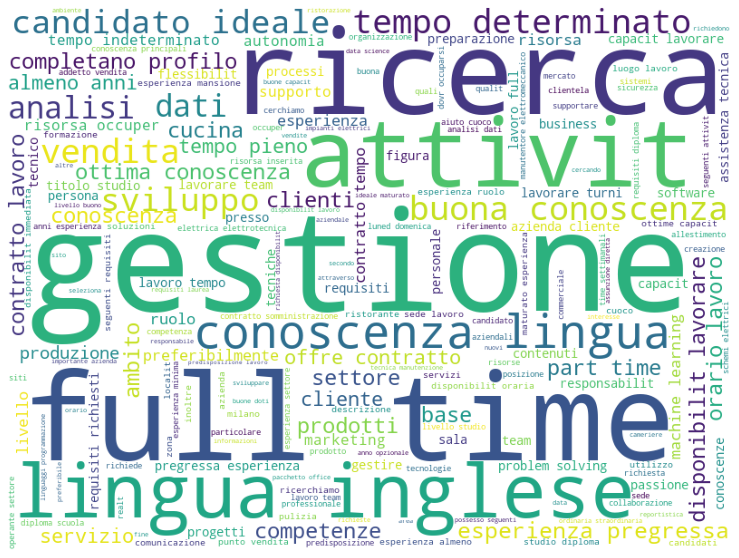

In [319]:
job_description = dati_aprile['Job_Description'].apply(lambda x: ' '.join(x))
cloud(' '.join(job_description)) # most common words

#### Remove words referring to: Comuni, Provincie, Regioni

In [439]:
# load a text file containing a list of 'Comuni, Provincie, Regioni' italiane
geo_data = pd.read_fwf('data/listacomuni.txt')
geo_data.to_csv('data/listacomuni.csv')
geo_data = pd.read_csv('data/listacomuni.csv', sep=';')
comune = [i.lower() for i in geo_data.Comune]
geo_data.Provincia = geo_data.Provincia.apply(lambda x: str(x))
provincia = [i.lower() for i in geo_data.Provincia]
regione = [i.lower() for i in geo_data.Regione] + ['lazio']
print('Comuni samples:',comune[:10])
print(20*'%')
print('Provincia samples:',provincia[:10])
print(20*'%')
print('Regione samples:',regione[:10])

Comuni samples: ['abano terme', 'abbadia cerreto', 'abbadia lariana', 'abbadia san salvatore', 'abbasanta', 'abbateggio', 'abbiategrasso', 'abetone', 'abriola', 'acate']
%%%%%%%%%%%%%%%%%%%%
Provincia samples: ['pd', 'lo', 'lc', 'si', 'or', 'pe', 'mi', 'pt', 'pz', 'rg']
%%%%%%%%%%%%%%%%%%%%
Regione samples: ['ven', 'lom', 'lom', 'tos', 'sar', 'abr', 'lom', 'tos', 'bas', 'sic']


In [443]:
def remove_comuni(data, column, geo_data):
    ''' function to remove geographic noisy'''
    comune = [i.lower() for i in geo_data.Comune]
    geo_data.Provincia = geo_data.Provincia.apply(lambda x: str(x))
    provincia = [i.lower() for i in geo_data.Provincia]
    regione = [i.lower() for i in geo_data.Regione]  + ['lazio']
    
    data[column] = data[column].apply(lambda x: [i for i in x if i not in comune])
    data[column] = data[column].apply(lambda x: [i for i in x if i not in provincia])
    data[column] = data[column].apply(lambda x: [i for i in x if i not in regione])
    
    return data

In [444]:
dati_aprile[['Target','Job_Description']].head()

,Target,Job_Description
576,commessi delle vendite al minuto,"[ricerca, addetti, vendite, auto, esperienza, ..."
126,cuochi in alberghi e ristoranti,"[sala, prestigiosissima, azienda, fashion, lux..."
326,tecnici web,"[full, stack, developer, programmazione, web, ..."
331,tecnici web,"[web, copywriter, gigasweb, lazio, candidato, ..."
204,statistici,"[cercando, business, intelligence, consultant,..."


In [445]:
dati_aprile = remove_comuni(dati_aprile, 'Job_Description', geo_data)
dati_aprile[['Target','Job_Description']].head()

,Target,Job_Description
576,commessi delle vendite al minuto,"[ricerca, addetti, vendite, auto, esperienza, ..."
126,cuochi in alberghi e ristoranti,"[sala, prestigiosissima, azienda, fashion, lux..."
326,tecnici web,"[full, stack, developer, programmazione, web, ..."
331,tecnici web,"[web, copywriter, gigasweb, candidato, dovr, a..."
204,statistici,"[cercando, business, intelligence, consultant,..."


##### Get rid of unusual_words : misspelled words - uncommon words¶

In [479]:
italian_vocab = pd.read_fwf('data/660000_parole_italiane.txt', names = ['word'])
italian_vocab = set(italian_vocab.word.tolist())
english_vocab = sorted(set(w.lower() for w in nltk.corpus.words.words())) # english vocabulary

In [480]:
def uncommon_words(data,column, italian_vocab, english_vocab = None):
    data[column] = data[column].apply(lambda x: [i for i in x if i in italian_vocab])
    return data

In [481]:
dati_aprile = uncommon_words(dati_aprile, 'Job_Description', italian_vocab, english_vocab)
dati_aprile[['Target','Job_Description']].head()# note that the word 'vimercate' is not present anymore

,Target,Job_Description
576,commessi delle vendite al minuto,"[ricerca, addetti, vendite, auto, esperienza, ..."
126,cuochi in alberghi e ristoranti,"[sala, azienda, fashion, ricerchiamo, supporti..."
326,tecnici web,"[full, programmazione, web, orienta, lavoro, e..."
331,tecnici web,"[web, copywriter, candidato, avere, seguenti, ..."
204,statistici,"[cercando, business, intelligence, maturato, a..."


                  Frequency
ELETTROMECCANICI           
manutenzione            179
impianti                151
esperienza              133
elettrici               103
conoscenza              100
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                 Frequency
CUOCHI IN ALBERGHI E RISTORANTI           
lavoro                                 105
cuoco                                   96
esperienza                              95
cucina                                  91
contratto                               69
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            Frequency
STATISTICI           
conoscenza        237
data              233
dati              176
analisi           157
esperienza        131
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
             Frequency
TECNICI WEB           


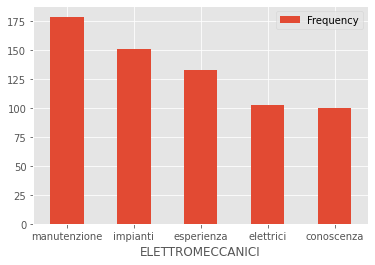

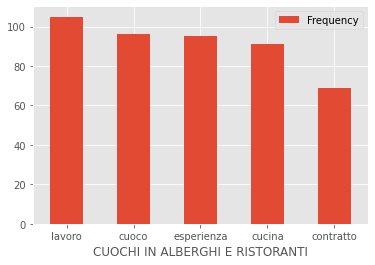

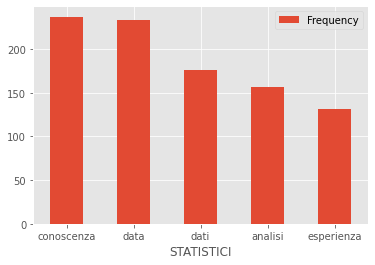

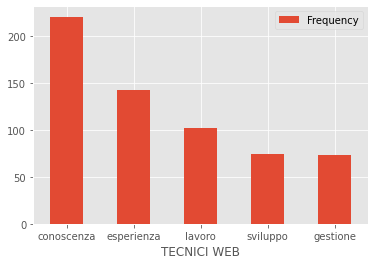

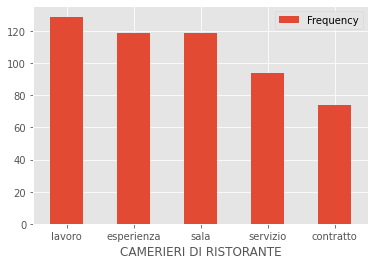

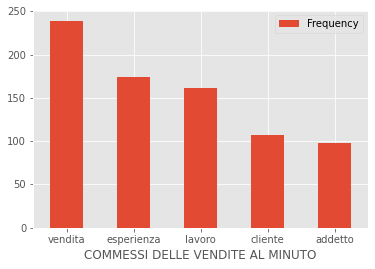

In [254]:
%matplotlib inline
matplotlib.style.use('ggplot')
field = "Job_Description"
Role = list(dati_aprile.Target.unique())
for i in Role:
    txt = dati_aprile[dati_aprile['Target']==i][field]
    txt = [i for x in txt.tolist() for i in x]
    words_except_stop_dist = nltk.FreqDist(w for w in txt) 
    words_except_stop_dist
    rslt = pd.DataFrame(words_except_stop_dist.most_common(5),
                            columns=[i.upper(), 'Frequency']).set_index(i.upper())
    print(rslt)
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)
    print(100 *'%')

##### Create Role dictionary and encode the column Role

In [260]:
Role_dictionary = pd.Series(dati_aprile['Target'].unique()).to_dict()
Role_dictionary = dict([(value, key) for key, value in Role_dictionary.items()])
Role_dictionary

{'elettromeccanici': 0,
 'cuochi in alberghi e ristoranti': 1,
 'statistici': 2,
 'tecnici web': 3,
 'camerieri di ristorante': 4,
 'commessi delle vendite al minuto': 5}

In [329]:
dati_aprile['Multi_Class'] = dati_aprile['Target'].apply(lambda x: Role_dictionary.get(x,'Unknown'))
dati_aprile[['Target','Multi_Class','Job_Description']]

,Target,Multi_Class,Job_Description
312,tecnici web,3,"[ruolo, incarico, candidato, inquadrato, ruolo..."
552,commessi delle vendite al minuto,5,"[addetto, booking, compito, valutare, richiest..."
82,elettromeccanici,0,"[manutentore, macchine, impianti, industriali,..."
362,tecnici web,3,"[esperto, assistenza, tecnica, sviluppo, assis..."
200,statistici,2,"[data, parte, team, cliente, fine, valutare, s..."
...,...,...,...
319,tecnici web,3,"[amministratore, sistema, figura, cercata, amm..."
507,commessi delle vendite al minuto,5,"[risorsa, inserita, punto, vendita, taglio, ca..."
481,camerieri di ristorante,4,"[seleziona, apprendista, cameriere, sala, peri..."
428,camerieri di ristorante,4,"[hotel, ristorante, zona, nord, ricerca, camer..."


#### Have a look at bigrams

In [332]:
# from nltk import bigrams, collocations
# Text = dati_aprile.Job_Description.iloc[1]
# bigrams_from_text = bigrams(Text)
# list(bigrams_from_text)[:6]

In [331]:
# bigrams_from_text = bigrams(Text)
# list(iter(dict(nltk.FreqDist(i for i in list(bigrams_from_text))).items()))[:6]

In [330]:
# dati_aprile.Job_Description = dati_aprile.Job_Description.apply(lambda x: ' '.join(x))
# dati_aprile.Job_Description.head()

### Data Split

In [268]:
X_train, X_test, y_train, y_test = train_test_split(dati_aprile['Job_Description'], 
                                                    dati_aprile['Multi_Class'],
                                                   test_size=0.20, random_state=42)

print('Number of rows in the total set: {}'.format(dati_aprile.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 650
Number of rows in the training set: 520
Number of rows in the test set: 130


In [485]:
X_train.apply(type)

333    <class 'str'>
29     <class 'str'>
553    <class 'str'>
286    <class 'str'>
425    <class 'str'>
           ...      
71     <class 'str'>
106    <class 'str'>
270    <class 'str'>
435    <class 'str'>
102    <class 'str'>
Name: Job_Description, Length: 520, dtype: object

### Bag of Words processing to our dataset

In [344]:
# list of text documents
text = ['Noi non stiamo scrivendo una pagina di un manuale di economia. Noi Stiamo scrivendo una pagina di un libro di Storia.']
print(text)
print(10*'#')
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)

print(vectorizer.vocabulary_)

# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(10*'#')
print('How many unique words do we have??',vector.shape[1])
print(10*'#')
print(vector.toarray())

['Noi non stiamo scrivendo una pagina di un manuale di economia. Noi Stiamo scrivendo una pagina di un libro di Storia.']
##########
{'noi': 4, 'non': 5, 'stiamo': 8, 'scrivendo': 7, 'una': 11, 'pagina': 6, 'di': 0, 'un': 10, 'manuale': 3, 'economia': 1, 'libro': 2, 'storia': 9}
##########
How many unique words do we have?? 12
##########
[[4 1 1 1 2 1 2 2 2 1 2 2]]


In [500]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

count_vector.fit(X_train)
# Fit the training data and then return the matrix
training_data = count_vector.transform(X_train)
with open("count_vector.pkl", 'wb') as handle:
                    pickle.dump(count_vector, handle)
        
with open("Role_dictionary.pkl", 'wb') as handle:
                pickle.dump(Role_dictionary, handle)       

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [489]:
training_data.data

array([1, 1, 1, ..., 1, 1, 1])

In [490]:
training_data.toarray().shape

(520, 4182)

In [491]:
print('training data',training_data.shape)
print('testing data',testing_data.shape)

training data (520, 4182)
testing data (130, 4182)


### Naive Bayes implementation

In [492]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [493]:
# Image(filename ="Naive.png", width=1000, height=300)

## P(Statistico|    Words = [dati, matematica, analisi, …...., inglese] )

In [494]:
def get_key(value, dictionary):
    for k,v in dictionary.items():
        if value == v:
            return k

In [498]:
import joblib
joblib.dump(naive_bayes, 'model.sav')

['model.sav']

In [501]:
predictions = naive_bayes.predict(testing_data)
predictions_keys = []
for i in predictions:
    predictions_keys.append(get_key(i,Role_dictionary))
print('Prediction for rows {} are \n {}'.format(X_test.index.tolist()[:10],predictions_keys[:10]))

print(100*'%')
actual_predictions = []
for i in y_test.tolist():
    actual_predictions.append(get_key(i,Role_dictionary))
print('actual predictions are: \n {}'.format(actual_predictions[:10]))

Prediction for rows [637, 220, 428, 326, 72, 516, 181, 131, 231, 277] are 
 ['commessi delle vendite al minuto', 'statistici', 'camerieri di ristorante', 'tecnici web', 'elettromeccanici', 'commessi delle vendite al minuto', 'cuochi in alberghi e ristoranti', 'cuochi in alberghi e ristoranti', 'statistici', 'statistici']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
actual predictions are: 
 ['commessi delle vendite al minuto', 'statistici', 'camerieri di ristorante', 'tecnici web', 'elettromeccanici', 'commessi delle vendite al minuto', 'cuochi in alberghi e ristoranti', 'cuochi in alberghi e ristoranti', 'statistici', 'statistici']


In [502]:
# check the accuracy of our model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test,predictions)))

Accuracy score:  0.9692307692307692


In [504]:
predictions = naive_bayes.predict_proba(testing_data)

In [507]:
np.array([l.argmax() for l in predictions])

array([5, 2, 4, 3, 0, 5, 1, 1, 2, 2, 5, 2, 2, 0, 5, 2, 3, 5, 0, 0, 3, 0,
       4, 0, 5, 5, 4, 2, 5, 0, 4, 0, 1, 4, 5, 2, 1, 5, 2, 1, 1, 3, 5, 0,
       4, 0, 3, 2, 2, 4, 5, 0, 4, 3, 0, 3, 1, 4, 0, 2, 0, 4, 1, 3, 4, 4,
       4, 5, 1, 4, 0, 3, 0, 4, 2, 0, 2, 3, 0, 5, 5, 5, 1, 5, 2, 4, 0, 2,
       2, 5, 1, 1, 0, 3, 4, 0, 5, 3, 2, 1, 5, 1, 0, 5, 1, 3, 5, 0, 4, 1,
       0, 5, 0, 3, 3, 3, 1, 0, 2, 5, 3, 3, 5, 1, 2, 5, 3, 3, 2, 5])